In [1]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.under_sampling import TomekLinks
from scipy.stats.mstats import winsorize
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import seaborn as sns

from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score


In [38]:
### V2 Millan
data = pd.read_csv("../raw_data/creditcard.csv")

# Remove duplicate rows
#data = data.drop_duplicates().reset_index(drop=True)

data['Hour'] = (data['Time'] // 3600) % 24

    ## split the data
X = data.drop(columns = ['Class'])
y = data['Class']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy=0.3, random_state=42)  # Adjust ratio if needed
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define function for log transformation
log_transformer = FunctionTransformer(lambda X: np.log1p(X), validate=False)
# Define cyclical encoding transformation
cyclical_transformer = FunctionTransformer(lambda X: np.column_stack((
    np.sin(2 * np.pi * X / 24),
    np.cos(2 * np.pi * X / 24)
)), validate=False)


# Define pipeline for 'Amount' - first apply scaling, then log transform
amount_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('log_transform', log_transformer)
])

# Define ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(transformers=[
('time_scaler', RobustScaler(), ['Time']),  # Scale 'Time' only
('amount_pipeline', amount_pipeline, ['Amount']),  # Apply scaling + log transform to 'Amount'
('hour_cyclical', cyclical_transformer, ['Hour'])  # Apply sine and cosine encoding to 'Hour'
], remainder='passthrough')  # Keep other columns

# Apply the transformation
X_train_transformed = preprocessor.fit_transform(X_train_smote)
X_test_transformed = preprocessor.transform(X_test)
X_val_transformed = preprocessor.transform(X_val)

# Convert back to DataFrame with proper column
columns = ['Time', 'Log_Amount', 'Hour_sin', 'Hour_cos'] + [col for col in X_train_smote.columns if col not in ['Time', 'Amount', 'Hour']]
X_train_transformed = pd.DataFrame(X_train_transformed, columns=columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=columns)
X_val_transformed = pd.DataFrame(X_val_transformed, columns=columns)


In [39]:
X_train = X_train_transformed.copy()
X_test = X_test_transformed.copy()
X_val = X_val_transformed.copy()
y_train = y_train_smote.copy()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train Logistic Regression model with L2 regularization
log_model = LogisticRegression(
    penalty='l1',         # L2 Regularization (default)
    C=10.0,                # Regularization strength (lower = stronger regularization)
    max_iter=1000,
    class_weight='balanced',
    solver="liblinear"
)
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Evaluate Model Performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     42644
           1       0.14      0.91      0.24        77

    accuracy                           0.99     42721
   macro avg       0.57      0.95      0.62     42721
weighted avg       1.00      0.99      0.99     42721

AUC-ROC Score: 0.9494568137050081


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     35544
           1       0.14      0.91      0.24        57

    accuracy                           0.99     35601
   macro avg       0.57      0.95      0.62     35601
weighted avg       1.00      0.99      0.99     35601

AUC-ROC Score: 0.9514560159683475

/tmp/ipykernel_139003/1542606506.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((1, 1), 1, 1, fill=True, color='red', alpha=0.5, edgecolor="black", lw=3))


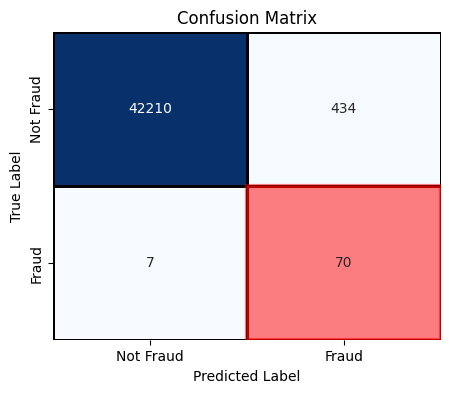

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define a colormap where fraud-fraud cell (1,1) is red
cmap = sns.color_palette("Blues", as_cmap=True)

# Create figure and heatmap
plt.figure(figsize=(5, 4))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=['Not Fraud', 'Fraud'],
                 yticklabels=['Not Fraud', 'Fraud'], linewidths=1, linecolor="black", cbar=False)

# Highlight the (1,1) cell (Fraud-Fraud) in red without covering text
ax.add_patch(plt.Rectangle((1, 1), 1, 1, fill=True, color='red', alpha=0.5, edgecolor="black", lw=3))

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
log_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Evaluate Model Performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     35409
           1       0.11      0.84      0.20        57

    accuracy                           0.99     35466
   macro avg       0.56      0.92      0.60     35466
weighted avg       1.00      0.99      0.99     35466

AUC-ROC Score: 0.9156726434403385


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced'),
                           param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best C:", grid_search.best_params_['C'])


Best C: 100


/tmp/ipykernel_139003/1542606506.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((1, 1), 1, 1, fill=True, color='red', alpha=0.5, edgecolor="black", lw=3))


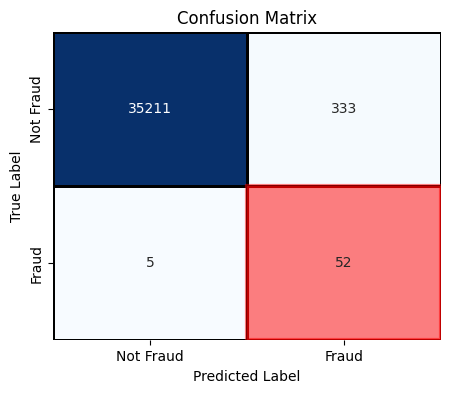

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define a colormap where fraud-fraud cell (1,1) is red
cmap = sns.color_palette("Blues", as_cmap=True)

# Create figure and heatmap
plt.figure(figsize=(5, 4))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=['Not Fraud', 'Fraud'],
                 yticklabels=['Not Fraud', 'Fraud'], linewidths=1, linecolor="black", cbar=False)

# Highlight the (1,1) cell (Fraud-Fraud) in red without covering text
ax.add_patch(plt.Rectangle((1, 1), 1, 1, fill=True, color='red', alpha=0.5, edgecolor="black", lw=3))

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()


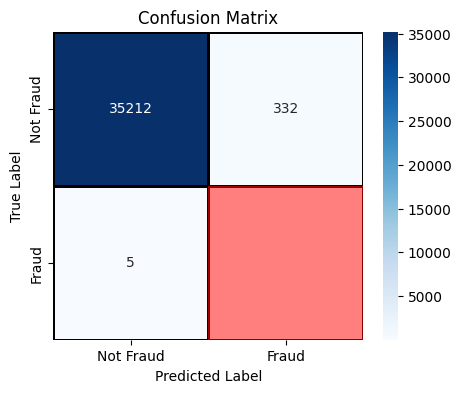

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a color mask for custom coloring
mask = np.zeros_like(cm, dtype=bool)
mask[1, 1] = True  # Only highlight bottom-right cell (Fraud-Fraud)

# Define a custom color palette
cmap = sns.color_palette("Blues", as_cmap=True)

# Plot the heatmap
plt.figure(figsize=(5, 4))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=['Not Fraud', 'Fraud'],
                 yticklabels=['Not Fraud', 'Fraud'], mask=mask, linewidths=1, linecolor="black")

# Overlay the red color on the (1,1) cell
ax.add_patch(plt.Rectangle((1, 1), 1, 1, fill=True, color='red', alpha=0.5))

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()


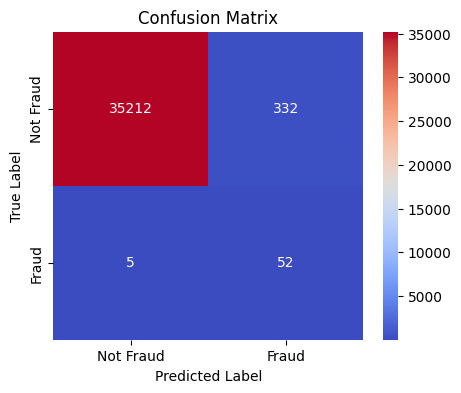

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using Seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap= "coolwarm", xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

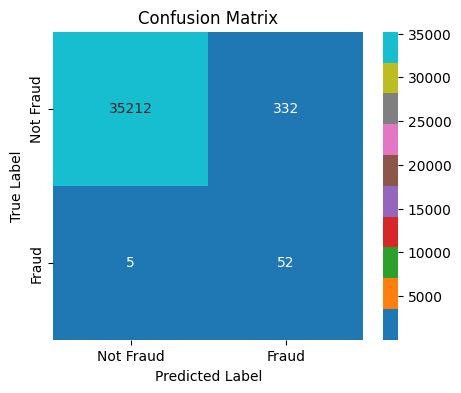

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define distinct color palette
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="tab10", xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score


# Convert classes to numpy array
classes = np.array([0, 1])


# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_smote)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}


# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Helps prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['AUC'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val_transformed, y_val),
                    epochs=30, batch_size=64,
                    class_weight=class_weights_dict,
                    verbose=0)

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print performance metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob))


2025-03-20 15:44:42.294154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 15:44:44.718216: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 15:44:55.526357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1113/1113 [==============================] - 2s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35544
           1       0.67      0.86      0.75        57

    accuracy                           1.00     35601
   macro avg       0.84      0.93      0.88     35601
weighted avg       1.00      1.00      1.00     35601

AUC-ROC Score: 0.9781814780593165


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Function to create model
def create_model(learning_rate=0.001, neurons=64, dropout_rate=0.2):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train_transformed.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons//2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

    return model

# Wrap Keras model for Scikit-learn
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define parameter grid
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'neurons': [64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [32, 64]
}

# Perform Randomized Search
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                 n_iter=10, scoring='roc_auc', cv=3, verbose=0, n_jobs=-1)

# Train the model with best parameters
grid_search.fit(X_train_transformed, y_train_smote)

# Get best model
best_model = grid_search.best_estimator_


2025-03-20 16:28:48.875409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 16:28:49.179867: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/tmp/ipykernel_107423/3894473765.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)
2025-03-20 16:28:54.402111: I tensor

: 

In [4]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define the model
brf = BalancedRandomForestClassifier(random_state=42)

# Define a reduced parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(brf, param_grid, scoring='roc_auc', cv=3, n_iter=20, n_jobs=1, verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get best model
best_brf = random_search.best_estimator_

# Make predictions
y_pred = best_brf.predict(X_test)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35544
           1       0.75      0.88      0.81        57

    accuracy                           1.00     35601
   macro avg       0.87      0.94      0.90     35601
weighted avg       1.00      1.00      1.00     35601

AUC-ROC Score: 0.9383573510074985


In [21]:
import numpy as np
X_train['Amount_log'] = np.log1p(X_train['Amount'])
X_test['Amount_log'] = np.log1p(X_test['Amount'])


In [ ]:

data1 = pd.read_csv('raw_data/creditcard.csv')
df = data1.copy()

# Remove duplicate rows
#df = df.drop_duplicates().reset_index(drop=True)

# Extract transaction hour and apply cyclical transformation
df['Hour'] = (df['Time'] // 3600) % 24
# Apply cyclical transformation
df["Hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
df["Hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)
df.drop(columns=["Hour", "Time"], inplace=True)

# Define features and labels
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Original class distribution befor SMOTE in first part:", Counter(y))

# Apply BorderlineSMOTE (instead of regular SMOTE)
smote = BorderlineSMOTE(sampling_strategy=0.3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


print("Original class distribution after SMOTE in first part:", Counter(y_train_smote))

#y_train_smote= pd.DataFrame(y_train_smote)

scaler = RobustScaler()
X_train_smote.iloc[:, 1:29] = scaler.fit_transform(X_train_smote.iloc[:, 1:29])
X_test.iloc[:, 1:29] = scaler.transform(X_test.iloc[:, 1:29])
X_val.iloc[:, 1:29] = scaler.transform(X_val.iloc[:, 1:29])

columns_to_winsorize = ["V8", "V18", "V21", "V27", "V28"]
for col in columns_to_winsorize:
    X_train_smote[col] = winsorize(X_train_smote[col], limits=[0.01, 0.01])
    X_test[col] = winsorize(X_test[col], limits=[0.01, 0.01])
    X_val[col] = winsorize(X_val[col], limits=[0.01, 0.01])

X_train_smote['V20'] = np.log(X_train_smote['V20'].clip(lower=0.0001))
X_train_smote['V23'] = np.log(X_train_smote['V23'].clip(lower=0.0001))
X_test['V20'] = np.log(X_test['V20'].clip(lower=0.0001))
X_test['V23'] = np.log(X_test['V23'].clip(lower=0.0001))
X_val['V20'] = np.log(X_val['V20'].clip(lower=0.0001))
X_val['V23'] = np.log(X_val['V23'].clip(lower=0.0001))

X_train_smote["Amount"] = np.log1p(X_train_smote["Amount"])  # log(1 + Amount) to handle zero values
X_test["Amount"] = np.log1p(X_test["Amount"])  # log(1 + Amount) to handle zero values
X_val["Amount"] = np.log1p(X_val["Amount"])


scaler = StandardScaler()
X_train_smote["Amount"] = scaler.fit_transform(X_train_smote[["Amount"]])
X_test["Amount"] = scaler.transform(X_test[["Amount"]])
X_val["Amount"] = scaler.transform(X_val[["Amount"]])

X_train_smote["Amount"] = winsorize(X_train_smote["Amount"], limits=[0.01, 0.01])
X_test["Amount"] = winsorize(X_test["Amount"], limits=[0.01, 0.01])
X_val["Amount"] = winsorize(X_val["Amount"], limits=[0.01, 0.01])

# Ensure all features are scaled if necessary (PCA is sensitive to feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

"""n_components = 24
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)"""

print("Original class distribution befor Tomek:", Counter(y_train_smote))


# Apply Tomek Links only if class imbalance remains
tomek = TomekLinks()
X_final, y_final = tomek.fit_resample(X_train_scaled, y_train_smote)

# Check final class distribution
print("After Tomek Links:", Counter(y_final))


Original class distribution befor SMOTE in first part: Counter({0: 284315, 1: 492})
Original class distribution after SMOTE in first part: Counter({0: 213236, 1: 63970})
Original class distribution befor Tomek: Counter({0: 213236, 1: 63970})
After Tomek Links: Counter({0: 213229, 1: 63970})


In [4]:
X_train = pd.DataFrame(X_final, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X.columns)

In [5]:
X_val.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour_sin',
       'Hour_cos'],
      dtype='object')

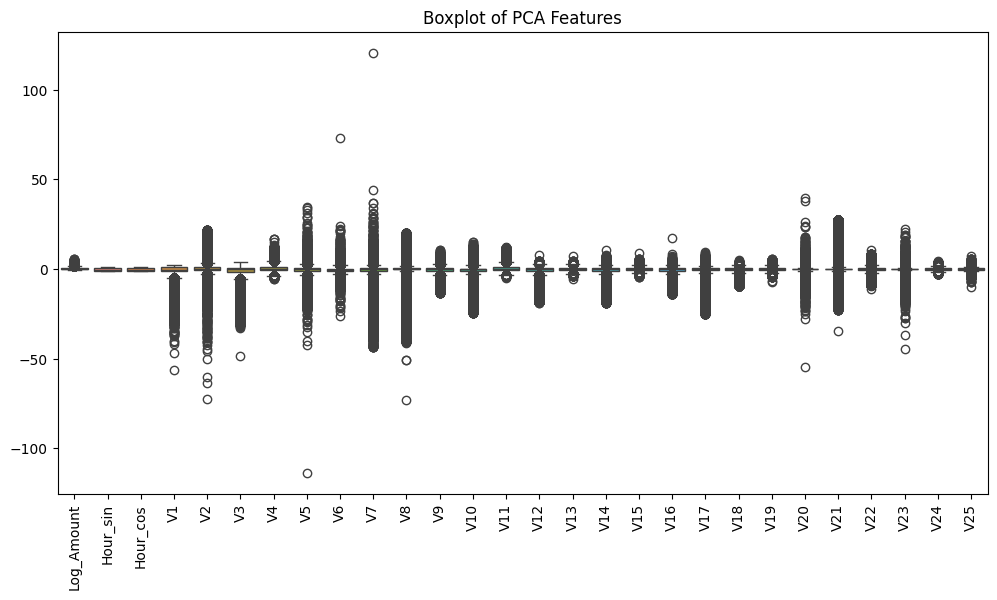

In [4]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train.iloc[:, 1:29])  # Excluding 'Time', 'Amount', 'Hour', 'Class'
plt.xticks(rotation=90)
plt.title("Boxplot of PCA Features")
plt.show()


In [4]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Balanced Random Forest model

In [7]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the Balanced Random Forest model
model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35409
           1       0.91      0.75      0.83        57

    accuracy                           1.00     35466
   macro avg       0.96      0.88      0.91     35466
weighted avg       1.00      1.00      1.00     35466

AUC-ROC Score: 0.8771364996410369


In [8]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define the model
brf = BalancedRandomForestClassifier(random_state=42)

# Define a reduced parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(brf, param_grid, scoring='roc_auc', cv=3, n_iter=20, n_jobs=1, verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get best model
best_brf = random_search.best_estimator_

# Make predictions
y_pred = best_brf.predict(X_test)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35409
           1       0.84      0.75      0.80        57

    accuracy                           1.00     35466
   macro avg       0.92      0.88      0.90     35466
weighted avg       1.00      1.00      1.00     35466

AUC-ROC Score: 0.8770800168259334


In [4]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider
}

# Initialize the Balanced Random Forest model
brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Grid Search
grid_search = GridSearchCV(brf, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model
best_brf = grid_search.best_estimator_
y_pred_best = best_brf.predict(X_test)

# Output results
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred_best))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_best))


Fitting 3 folds for each of 162 candidates, totalling 486 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [7]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

# Randomized search
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

# Evaluate best model
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Updated Classification Report:\n", classification_report(y_test, y_pred_best))
print("Updated AUC-ROC Score:", roc_auc_score(y_test, y_pred_best))


Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Updated Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35544
           1       0.74      0.88      0.80        57

    accuracy                           1.00     35601
   macro avg       0.87      0.94      0.90     35601
weighted avg       1.00      1.00      1.00     35601

Updated AUC-ROC Score: 0.9383432839357002


# Logistic Regression model

In [5]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
log_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Evaluate Model Performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     35544
           1       0.14      0.91      0.24        57

    accuracy                           0.99     35601
   macro avg       0.57      0.95      0.62     35601
weighted avg       1.00      0.99      0.99     35601

AUC-ROC Score: 0.9514700830401459


In [6]:
log_model_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000, class_weight='balanced')
log_model_l1.fit(X_train, y_train)
# Make predictions
y_pred = log_model.predict(X_test)

# Evaluate Model Performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     35544
           1       0.14      0.91      0.24        57

    accuracy                           0.99     35601
   macro avg       0.57      0.95      0.62     35601
weighted avg       1.00      0.99      0.99     35601

AUC-ROC Score: 0.9514841501119442


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # L1 for feature selection, L2 for stability
    'solver': ['liblinear', 'saga']  # 'liblinear' for small datasets, 'saga' for large
}

# Initialize Logistic Regression model
log_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Perform Grid Search
grid_search = GridSearchCV(log_model, param_grid, scoring='recall', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_log_model = grid_search.best_estimator_
y_pred = best_log_model.predict(X_test)

# Print classification report

print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     35544
           1       0.14      0.91      0.24        57

    accuracy                           0.99     35601
   macro avg       0.57      0.95      0.62     35601
weighted avg       1.00      0.99      0.99     35601

AUC-ROC Score: 0.9514560159683475


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

Classification Report (Adjusted Threshold):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     35544
           1       0.07      0.91      0.13        57

    accuracy                           0.98     35601
   macro avg       0.53      0.95      0.56     35601
weighted avg       1.00      0.98      0.99     35601

AUC-ROC Score (Adjusted Threshold): 0.9463918701209472


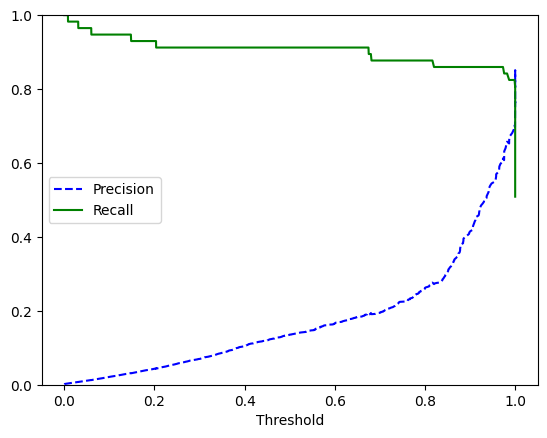

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report (GridSearchCV):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     35544
           1       0.14      0.91      0.24        57

    accuracy                           0.99     35601
   macro avg       0.57      0.95      0.62     35601
weighted avg       1.00      0.99      0.99     35601

AUC-ROC Score (GridSearchCV): 0.9514560159683475


In [5]:
from sklearn.linear_model import LogisticRegression
# --- Logistic Regression with Threshold Adjustment ---
log_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)
y_proba = log_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
threshold = 0.3  # Adjust threshold as needed
y_pred_threshold = (y_proba > threshold).astype(int)
print("Classification Report (Adjusted Threshold):\n", classification_report(y_test, y_pred_threshold))
print("AUC-ROC Score (Adjusted Threshold):", roc_auc_score(y_test, y_pred_threshold))

# --- Plot Precision-Recall Curve ---
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.ylim([0, 1])
plt.show()

# --- GridSearchCV (Optional) ---
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000), param_grid, scoring='recall', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_log_model = grid_search.best_estimator_
y_pred_grid = best_log_model.predict(X_test)
print("Classification Report (GridSearchCV):\n", classification_report(y_test, y_pred_grid))
print("AUC-ROC Score (GridSearchCV):", roc_auc_score(y_test, y_pred_grid))


## new method

In [22]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
log_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Evaluate Model Performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     35544
           1       0.04      0.93      0.08        57

    accuracy                           0.97     35601
   macro avg       0.52      0.95      0.53     35601
weighted avg       1.00      0.97      0.98     35601

AUC-ROC Score: 0.9474691116718197


/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
import numpy as np

# Get predicted probabilities
y_prob = best_log_model.predict_proba(X_test)[:, 1]  # Probability for class 1 (fraud)

# Adjust the threshold (e.g., 0.2 instead of 0.5)
threshold = 0.2
y_pred_adjusted = (y_prob > threshold).astype(int)

# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_adjusted))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     35544
           1       0.04      0.93      0.08        57

    accuracy                           0.97     35601
   macro avg       0.52      0.95      0.53     35601
weighted avg       1.00      0.97      0.98     35601

AUC-ROC Score: 0.9484538066977031


In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE only to the training set
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Logistic Regression on SMOTE data
log_model_smote = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_model_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_smote = log_model_smote.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred_smote))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_smote))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     35544
           1       0.13      0.91      0.23        57

    accuracy                           0.99     35601
   macro avg       0.57      0.95      0.61     35601
weighted avg       1.00      0.99      0.99     35601

AUC-ROC Score: 0.9513856806093559


In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight=100, random_state=42, n_estimators=100, max_depth=5)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_xgb))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35544
           1       0.74      0.88      0.80        57

    accuracy                           1.00     35601
   macro avg       0.87      0.94      0.90     35601
weighted avg       1.00      1.00      1.00     35601

AUC-ROC Score: 0.9383432839357002


In [12]:
from xgboost import XGBClassifier

# Initialize XGBoost with imbalance handling
xgb_model = XGBClassifier(
    scale_pos_weight=10,  # Helps in handling class imbalance
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35544
           1       0.80      0.86      0.83        57

    accuracy                           1.00     35601
   macro avg       0.90      0.93      0.92     35601
weighted avg       1.00      1.00      1.00     35601

AUC-ROC Score: 0.9514560159683475


In [13]:
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_xgb))

AUC-ROC Score: 0.9296557565419288


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

# Define hyperparameter grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [5, 10, 15]
}

# Initialize XGBoost model
xgb_model = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Use Stratified K-Fold
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,  # Try 10 random combinations
    scoring='roc_auc',
    cv=cv_strategy,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

# Train the model
random_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", random_search.best_params_)

# Predict with the best model
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_best))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_best))


/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:57:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:57:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:57:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, 

Best Parameters: {'scale_pos_weight': 10, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35544
           1       0.81      0.84      0.83        57

    accuracy                           1.00     35601
   macro avg       0.91      0.92      0.91     35601
weighted avg       1.00      1.00      1.00     35601

AUC-ROC Score: 0.9208978937891656


In [6]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define hyperparameter grid
param_grid = {
    'max_depth': [4, 6, 8],          # Try different tree depths
    'learning_rate': [0.01, 0.05, 0.1],  # Try smaller learning rates
    'n_estimators': [100, 200, 300],   # Number of boosting rounds
    'scale_pos_weight': [5, 10, 15]  # Adjust for class imbalance
}

# Initialize XGBoost
xgb_model = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for AUC-ROC score
    cv=3,  # 3-Fold Cross Validation
    verbose=0,
    n_jobs=-1
)

# Train on training data
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Predict with the best model
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_best))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_best))


/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:58:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:58:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:58:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:58:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'scale_pos_weight': 10}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35544
           1       0.96      0.82      0.89        57

    accuracy                           1.00     35601
   macro avg       0.98      0.91      0.94     35601
weighted avg       1.00      1.00      1.00     35601

AUC-ROC Score: 0.9122525676107893


In [8]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define hyperparameter grid
param_grid = {
    'max_depth': [4, 6, 8],          # Try different tree depths
    'learning_rate': [0.01, 0.05, 0.1],  # Try smaller learning rates
    'n_estimators': [100, 200, 300],   # Number of boosting rounds
    'scale_pos_weight': [5, 10, 15]  # Adjust for class imbalance
}

# Initialize XGBoost
xgb_model = XGBClassifier(
    eval_metric="aucpr",  # Try 'aucpr' instead of 'logloss'
    scale_pos_weight=10,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    use_label_encoder=False,
    random_state=42
)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for AUC-ROC score
    cv=3,  # 3-Fold Cross Validation
    verbose=0,
    n_jobs=-1
)

# Train on training data
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Predict with the best model
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_best))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_best))


/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:08:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:08:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:08:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:08:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'scale_pos_weight': 15}


NameError: name 'classification_report' is not defined

In [10]:
print(classification_report(y_test, y_pred_best))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35544
           1       0.79      0.86      0.82        57

    accuracy                           1.00     35601
   macro avg       0.90      0.93      0.91     35601
weighted avg       1.00      1.00      1.00     35601

AUC-ROC Score: 0.9296416894701305


In [29]:
import sklearn
import xgboost
print("scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)

scikit-learn version: 1.6.1
XGBoost version: 1.6.2


In [14]:
from lightgbm import LGBMClassifier

# Initialize LightGBM
lgbm_model = LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.05,
    n_estimators=200,
    scale_pos_weight=10,  # Handles class imbalance
    random_state=42
)

# Train the model
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_lgbm))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 42645, number of negative: 213226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 255871, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609443
[LightGBM] [Info] Start training from score -1.609443
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35544
           1       0.69      0.88      0.78        57

    accuracy                           1.00     35601
   macro avg       0.85      0.94      0.89     35601
weighted avg       1.00      1.00      1.00     35601

AUC-ROC Score: 0.9382870156485068


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, roc_auc_score

# Define the autoencoder architecture
input_dim = X_train.shape[1]

autoencoder = models.Sequential([
    layers.Dense(24, activation='relu', input_shape=(input_dim,)),
    layers.Dense(12, activation='relu'),
    layers.Dense(6, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(24, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')  # Output should match input
])

autoencoder.compile(optimizer='adam', loss='mse', )

# Train the autoencoder on non-fraud data
autoencoder.fit(X_train[y_train == 0], X_train[y_train == 0], epochs=10, batch_size=32)

# Reconstruction loss can help detect fraud
reconstruction = autoencoder.predict(X_test)
reconstruction_loss = tf.keras.losses.mean_squared_error(X_test, reconstruction)
threshold = np.percentile(reconstruction_loss, 95)

fraud_predictions = tf.cast(reconstruction_loss > threshold, tf.int32) # Use tf.cast
#or
#fraud_predictions = tf.cast(tf.greater(reconstruction_loss, threshold), tf.int32)

print(classification_report(y_test, fraud_predictions.numpy())) #convert to numpy array for the report.
print("AUC-ROC Score:", roc_auc_score(y_test, fraud_predictions.numpy())) #convert to numpy array for the report.

Epoch 1/10
6664/6664 [==============================] - 17s 2ms/step - loss: 0.8346
Epoch 2/10
6664/6664 [==============================] - 19s 3ms/step - loss: 0.7957
Epoch 3/10
6664/6664 [==============================] - 21s 3ms/step - loss: 0.7800
Epoch 4/10
6664/6664 [==============================] - 20s 3ms/step - loss: 0.7757
Epoch 5/10
6664/6664 [==============================] - 21s 3ms/step - loss: 0.7736
Epoch 6/10
6664/6664 [==============================] - 17s 3ms/step - loss: 0.7701
Epoch 7/10
6664/6664 [==============================] - 19s 3ms/step - loss: 0.7663
Epoch 8/10
6664/6664 [==============================] - 16s 2ms/step - loss: 0.7646
Epoch 9/10
6664/6664 [==============================] - 20s 3ms/step - loss: 0.7634
Epoch 10/10
1113/1113 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     35544
           1       0.03      0.84      0.05        57

    accurac

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import math
import os
import numpy as np
import pandas as pd

In [8]:


# Define the autoencoder model creation function
def create_autoencoder(input_dim):
    autoencoder = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid')
    ])
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Define the input dimension (replace X_train.shape[1] with the actual value)
input_dim = X_train.shape[1]

# Wrap the Keras model as a classifier
autoencoder_model = KerasClassifier(build_fn=create_autoencoder, input_dim=input_dim, epochs=10, batch_size=32)

# Define the hyperparameter grid for tuning
param_grid = {
    'epochs': [10, 20, 30],  # Number of training epochs
    'batch_size': [16, 32],  # Batch size
    'input_dim': [input_dim]  # Input dimension (you can experiment with other parameters)
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=autoencoder_model, param_grid=param_grid, cv=3, verbose=0)

# Define the custom callback to track the best result
class BestResultCallback(Callback):
    def __init__(self):
        super(BestResultCallback, self).__init__()
        self.best_loss = float('inf')  # Initialize with a very high value
        self.best_epoch = 0
        self.losses = []  # List to store the loss for each epoch

    def on_epoch_end(self, epoch, logs=None):
        # Save the loss for the current epoch
        self.losses.append(logs['loss'])

        # If the current loss is better than the previous best, update
        if logs['loss'] < self.best_loss:
            self.best_loss = logs['loss']
            self.best_epoch = epoch
            print(f"Epoch {epoch + 1}: Best loss so far {self.best_loss:.4f}")

    def get_best_results(self):
        return self.best_loss, self.best_epoch, self.losses


# Create the ModelCheckpoint callback to save the best model weights
checkpoint = ModelCheckpoint(
    'best_autoencoder.h5',  # Path to save the model
    monitor='loss',         # Monitor the training loss
    verbose=1,              # Print when saving the best weights
    save_best_only=True,    # Save only the best model
    restore_best_weights=True  # Restore the best weights after training
)

# Create the custom callback to track the best result
best_result_callback = BestResultCallback()

# Perform Grid Search with both callbacks
grid_search.fit(
    X_train[y_train == 0], X_train[y_train == 0],
    callbacks=[checkpoint, best_result_callback]
)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best results tracked by the custom callback
best_loss, best_epoch, losses = best_result_callback.get_best_results()
print(f"Best loss achieved: {best_loss:.4f} at epoch {best_epoch + 1}")

# Predict with the best model
best_autoencoder = grid_search.best_estimator_
reconstruction = best_autoencoder.predict(X_test)
reconstruction_loss = tf.keras.losses.mean_squared_error(X_test, reconstruction)
threshold = np.percentile(reconstruction_loss, 95)

fraud_predictions = tf.cast(reconstruction_loss > threshold, tf.int32)

# Evaluate
print(classification_report(y_test, fraud_predictions.numpy()))
print("AUC-ROC Score:", roc_auc_score(y_test, fraud_predictions.numpy()))


/tmp/ipykernel_94537/1301334812.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  autoencoder_model = KerasClassifier(build_fn=create_autoencoder, input_dim=input_dim, epochs=10, batch_size=32)


Epoch 1/10
8873/8885 [============================>.] - ETA: 0s - loss: 0.7290
Epoch 1: loss improved from inf to 0.72902, saving model to best_autoencoder.h5
Epoch 1: Best loss so far 0.7290
8885/8885 [==============================] - 27s 3ms/step - loss: 0.7290
Epoch 2/10
8870/8885 [============================>.] - ETA: 0s - loss: 0.6950
Epoch 2: loss improved from 0.72902 to 0.69552, saving model to best_autoencoder.h5
Epoch 2: Best loss so far 0.6955
8885/8885 [==============================] - 29s 3ms/step - loss: 0.6955
Epoch 3/10
8885/8885 [==============================] - ETA: 0s - loss: 0.6882
Epoch 3: loss improved from 0.69552 to 0.68815, saving model to best_autoencoder.h5
Epoch 3: Best loss so far 0.6882
8885/8885 [==============================] - 28s 3ms/step - loss: 0.6882
Epoch 4/10
8869/8885 [============================>.] - ETA: 0s - loss: 0.6831
Epoch 4: loss improved from 0.68815 to 0.68317, saving model to best_autoencoder.h5
Epoch 4: Best loss so far 0.6832
8

/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
  File "/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 335, in score
    raise ValueError(
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
8881/8885 [============================>.] - ETA: 0s - loss: 0.7378
Epoch 1: loss did not improve from 0.67387
8885/8885 [==============================] - 30s 3ms/step - loss: 0.7377
Epoch 2/10
8878/8885 [============================>.] - ETA: 0s - loss: 0.7002
Epoch 2: loss did not improve from 0.67387
8885/8885 [==============================] - 30s 3ms/step - loss: 0.7001
Epoch 3/10
8869/8885 [============================>.] - ETA: 0s - loss: 0.6946
Epoch 3: loss did not improve from 0.67387
8885/8885 [==============================] - 30s 3ms/step - loss: 0.6942
Epoch 4/10
8878/8885 [============================>.] - ETA: 0s - loss: 0.6908
Epoch 4: loss did not improve from 0.67387
8885/8885 [==============================] - 28s 3ms/step - loss: 0.6908
Epoch 5/10
8885/8885 [==============================] - ETA: 0s - loss: 0.6886
Epoch 5: loss did not improve from 0.67387
8885/8885 [==============================] - 25s 3ms/step - loss: 0.6886
Epoch 6/10
8885/8885 [===

/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
  File "/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 335, in score
    raise ValueError(
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
8874/8885 [============================>.] - ETA: 0s - loss: 0.7306
Epoch 1: loss did not improve from 0.67387
8885/8885 [==============================] - 25s 3ms/step - loss: 0.7306
Epoch 2/10
8875/8885 [============================>.] - ETA: 0s - loss: 0.6923
Epoch 2: loss did not improve from 0.67387
8885/8885 [==============================] - 39s 4ms/step - loss: 0.6924
Epoch 3/10
8871/8885 [============================>.] - ETA: 0s - loss: 0.6828
Epoch 3: loss did not improve from 0.67387
8885/8885 [==============================] - 27s 3ms/step - loss: 0.6830
Epoch 4/10
8875/8885 [============================>.] - ETA: 0s - loss: 0.6805
Epoch 4: loss did not improve from 0.67387
8885/8885 [==============================] - 26s 3ms/step - loss: 0.6803
Epoch 5/10
8447/8885 [===========================>..] - ETA: 1s - loss: 0.6776

KeyboardInterrupt: 

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Define a function to create the autoencoder model
def create_autoencoder(input_dim):
    autoencoder = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid')
    ])
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Define the input dimension (replace X_train.shape[1] with the actual value)
input_dim = X_train.shape[1]

# Wrap the Keras model as a classifier
autoencoder_model = KerasClassifier(build_fn=create_autoencoder, input_dim=input_dim, epochs=10, batch_size=32)

# Define the hyperparameter grid for tuning
param_grid = {
    'epochs': [10, 20, 30],  # Number of training epochs
    'batch_size': [16, 32],  # Batch size
    'input_dim': [input_dim]  # Input dimension (you can experiment with other parameters)
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=autoencoder_model, param_grid=param_grid, cv=3, verbose=0)

# Perform Grid Search
grid_search.fit(X_train[y_train == 0], X_train[y_train == 0])

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Predict with the best model
best_autoencoder = grid_search.best_estimator_
reconstruction = best_autoencoder.predict(X_test)
reconstruction_loss = tf.keras.losses.mean_squared_error(X_test, reconstruction)
threshold = np.percentile(reconstruction_loss, 95)

fraud_predictions = tf.cast(reconstruction_loss > threshold, tf.int32)

# Evaluate
print(classification_report(y_test, fraud_predictions.numpy()))
print("AUC-ROC Score:", roc_auc_score(y_test, fraud_predictions.numpy()))


/tmp/ipykernel_88225/4204032684.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  autoencoder_model = KerasClassifier(build_fn=create_autoencoder, input_dim=input_dim, epochs=10, batch_size=32)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


2025-03-19 14:27:44.174200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
8885/8885 [==============================] - 29s 3ms/step - loss: 0.7348
Epoch 2/10
8885/8885 [==============================] - 27s 3ms/step - loss: 0.7117
Epoch 3/10
8885/8885 [==============================] - 27s 3ms/step - loss: 0.7050
Epoch 4/10
8885/8885 [==============================] - 29s 3ms/step - loss: 0.7011
Epoch 5/10
8885/8885 [==============================] - 29s 3ms/step - loss: 0.6979
Epoch 6/10
8885/8885 [==============================] - 28s 3ms/step - loss: 0.6949
Epoch 7/10
8885/8885 [==============================] - 26s 3ms/step - loss: 0.6936
Epoch 8/10
8885/8885 [==============================] - 26s 3ms/step - loss: 0.6922
Epoch 9/10
8885/8885 [==============================] - 23s 3ms/step - loss: 0.6899
Epoch 10/10
4443/4443 [==============================] - 6s 1ms/step - loss: 0.4729
[CV] END .............batch_size=16, epochs=10, input_dim=32; total time= 4.7min


/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
  File "/home/mahdi/.pyenv/versions/lewagon/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 335, in score
    raise ValueError(
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/10
8885/8885 [==============================] - 28s 3ms/step - loss: 0.7378
Epoch 2/10
8885/8885 [==============================] - 31s 3ms/step - loss: 0.7001
Epoch 3/10
8885/8885 [==============================] - 29s 3ms/step - loss: 0.6940
Epoch 4/10
8885/8885 [==============================] - 28s 3ms/step - loss: 0.6910
Epoch 5/10
2839/8885 [========>.....................] - ETA: 16s - loss: 0.6856

KeyboardInterrupt: 

In [ ]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_scaled)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)

import joblib

# Save model
joblib.dump(best_model, "fraud_detection_model.pkl")

# Load model for future use
model_loaded = joblib.load("fraud_detection_model.pkl")


In [ ]:
import joblib

# Save the trained model
joblib.dump(best_model, "fraud_detection_model.pkl")

# Save the preprocessing pipeline as well
joblib.dump(preprocessor, "preprocessing_pipeline.pkl")

print("Model and preprocessing pipeline saved successfully!")


In [ ]:
pip install fastapi uvicorn joblib pandas numpy
uvicorn main:app --host 0.0.0.0 --port 8000 --reload


In [ ]:
from fastapi import FastAPI
import joblib
import numpy as np
import pandas as pd
from pydantic import BaseModel

# Load the trained model and preprocessing pipeline
model = joblib.load("fraud_detection_model.pkl")
preprocessor = joblib.load("preprocessing_pipeline.pkl")

# Initialize FastAPI app
app = FastAPI()

# Define the request format
class Transaction(BaseModel):
    V1: float
    V2: float
    V3: float
    V4: float
    V5: float
    V6: float
    V7: float
    V8: float
    V9: float
    V10: float
    V11: float
    V12: float
    V13: float
    V14: float
    V15: float
    V16: float
    V17: float
    V18: float
    V19: float
    V20: float
    V21: float
    V22: float
    V23: float
    V24: float
    V25: float
    V26: float
    V27: float
    V28: float
    Amount: float
    Hour: int

@app.get("/")
def home():
    return {"message": "Credit Card Fraud Detection API is running!"}

@app.post("/predict")
def predict(transaction: Transaction):
    # Convert input data to DataFrame
    input_data = pd.DataFrame([transaction.dict()])

    # Apply preprocessing
    input_scaled = preprocessor.transform(input_data)

    # Make prediction
    prediction = model.predict(input_scaled)
    prediction_proba = model.predict_proba(input_scaled)[:, 1]

    return {
        "fraud_prediction": int(prediction[0]),
        "fraud_probability": float(prediction_proba[0])
    }


In [9]:
pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 2.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.
